In [3]:
# S3 bucket and prefix
#bucket = 'solutionudacity20210905'
prefix = 'sagemaker/DEMO-data-distribution-types'

# Define IAM role
import boto3
import re
import sagemaker
from sagemaker.session import Session
from sagemaker import get_execution_role

session = sagemaker.Session()

bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-769654117898
AWS Region: us-east-1
RoleArn: arn:aws:iam::769654117898:role/service-role/AmazonSageMaker-ExecutionRole-20211230T131845


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import io
import time
import copy
import json
import sys
import sagemaker.amazon.common as smac
import os

In [5]:
def get_gdelt(filename):
    s3 = boto3.resource('s3')
    s3.Bucket('gdelt-open-data').download_file('events/' + filename, '.gdelt.csv')
    df = pd.read_csv('.gdelt.csv', sep='\t')
    header = pd.read_csv('https://www.gdeltproject.org/data/lookups/CSV.header.historical.txt', sep='\t')
    df.columns = header.columns
    return df

In [6]:
data = get_gdelt('1979.csv')
data

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,Actor2Geo_Long,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED
0,1,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,8.0000,0,1.0,Nigeria,NI,NI,10.0000,8.0000,0.0,20130203
1,2,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,8.0000,0,1.0,Nigeria,NI,NI,10.0000,8.0000,0.0,20130203
2,3,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,106.3590,-1903584,4.0,"Dizhou, Guangxi, China",CH,CH16,23.0036,106.3590,-1903584.0,20130203
3,4,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,-96.8067,1380944,3.0,"Dallas, Texas, United States",US,USTX,32.7831,-96.8067,1380944.0,20130203
4,5,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,34.6809,-779676,4.0,"Emunim, HaDarom, Israel",IS,IS01,31.7444,34.6809,-779676.0,20130203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430935,230397975,19791231,197912,1979,1979.9890,USA,UNITED STATES,USA,NaN,NaN,...,51.5148,10074674,4.0,"Tehran, Tehran, Iran",IR,IR26,35.7500,51.5148,10074674.0,20130206
430936,230397976,19791231,197912,1979,1979.9890,USA,UNITED STATES,USA,NaN,NaN,...,51.5148,10074674,4.0,"Tehran, Tehran, Iran",IR,IR26,35.7500,51.5148,10074674.0,20130206
430937,230397977,19791231,197912,1979,1979.9890,USA,WASHINGTON,USA,NaN,NaN,...,65.0000,-2089022,4.0,"Moscow, Moskva, Russia",RS,RS48,55.7522,37.6156,-2960561.0,20130206
430938,230397978,19791231,197912,1979,1979.9890,VNM,VIETNAM,VNM,NaN,NaN,...,0.0000,0,1.0,France,FR,FR,46.0000,2.0000,0.0,20130206


,NumArticles,AvgTone,Actor1Geo_Lat,Actor1Geo_Long,Actor2Geo_Lat,Actor2Geo_Long
count,430940.000000,430940.000000,430940.000000,430940.000000,430940.000000,430940.000000
mean,4.369694,5.127215,26.311911,26.111038,23.109048,23.637813
std,3.121310,2.637798,21.865323,61.125843,22.136466,57.693612
min,1.000000,0.000000,-85.622100,-179.050000,-85.622100,-179.050000
25%,2.000000,3.333333,10.000000,0.000000,0.000000,0.000000
50%,4.000000,5.000000,32.000000,28.229400,30.044500,19.500000
75%,6.000000,6.666667,40.400000,53.000000,39.928900,50.093800
max,54.000000,28.571429,85.000000,180.000000,85.000000,180.000000


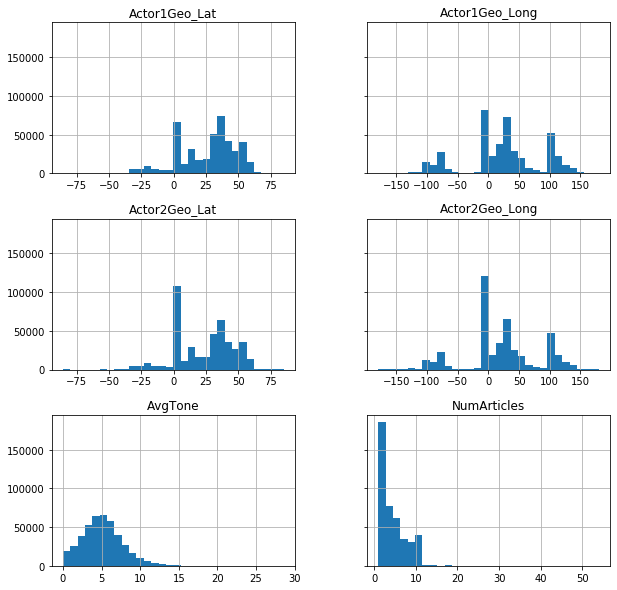

In [9]:
data = data[['EventCode', 'NumArticles', 'AvgTone', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor2Geo_Lat', 'Actor2Geo_Long']]
data['EventCode'] = data['EventCode'].astype(object)

#for column in data.select_dtypes(include=['object']).columns:
#    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))

display(data.describe())
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))
plt.show()

In [10]:
events = pd.crosstab(index=data['EventCode'], columns='count').sort_values(by='count', ascending=False).index[:20]

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

## Similarly doing for other years

In [11]:
def write_to_s3(bucket, prefix, channel, file_prefix, X, y):
    buf = io.BytesIO()
    smac.write_numpy_to_dense_tensor(buf, X.astype('float32'), y.astype('float32'))
    buf.seek(0)
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, channel, file_prefix + '.data')).upload_fileobj(buf)

def transform_gdelt(df, events=None):
    df = df[['AvgTone', 'EventCode', 'NumArticles', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor2Geo_Lat', 'Actor2Geo_Long']]
    df['EventCode'] = df['EventCode'].astype(object)
    if events is not None:
        df = df[np.in1d(df['EventCode'], events)]
    return pd.get_dummies(df[((df['Actor1Geo_Lat'] == 0) & (df['Actor1Geo_Long'] == 0) != True) &
                                   ((df['Actor2Geo_Lat'] == 0) & (df['Actor2Geo_Long'] == 0) != True)])
    
def prepare_gdelt(bucket, prefix, file_prefix, events=None, random_state=1729):
    df = get_gdelt(file_prefix + '.csv')
    model_data = transform_gdelt(df, events)
#    train_data, validation_data = np.split(model_data.sample(frac=1, random_state=random_state).as_matrix(), 
#                                           [int(0.9 * len(model_data))])
    train_data, validation_data = np.split(model_data.sample(frac=1, random_state=random_state).values, 
                                           [int(0.9 * len(model_data))])

    write_to_s3(bucket, prefix, 'train', file_prefix, train_data[:, 1:], train_data[:, 0])
    write_to_s3(bucket, prefix, 'validation', file_prefix, validation_data[:, 1:], validation_data[:, 0])

In [12]:
for year in range(1979, 1984):
    prepare_gdelt(bucket, prefix, str(year), events)

NameError: name 'events' is not defined

In [45]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/linear-learner:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/linear-learner:latest'}
container = containers[boto3.Session().region_name]

In [46]:
common_training_params = {
    "RoleArn": role,
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.c4.2xlarge",#,#"ml.t3.medium",#"ml.c5.xlarge",#"ml.m4.xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix)
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }

    ],
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/".format(bucket, prefix)
    },
    "HyperParameters": {
        "feature_dim": "25",
        "mini_batch_size": "500",
        "predictor_type": "regressor",
        "epochs": "2",
        "num_models": "32",
        "loss": "absolute_loss"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}

In [47]:
sharded_job = 'DEMO-linear-sharded-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", sharded_job)

sharded_training_params = copy.deepcopy(common_training_params)
sharded_training_params['TrainingJobName'] = sharded_job
sharded_training_params['InputDataConfig'][0]['DataSource']['S3DataSource']['S3DataDistributionType'] = 'ShardedByS3Key'

Job name is: DEMO-linear-sharded-2021-09-05-21-57-54


In [48]:
replicated_job = 'DEMO-linear-replicated-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", replicated_job)

replicated_training_params = copy.deepcopy(common_training_params)
replicated_training_params['TrainingJobName'] = replicated_job
replicated_training_params['InputDataConfig'][0]['DataSource']['S3DataSource']['S3DataDistributionType'] = 'FullyReplicated'

Job name is: DEMO-linear-replicated-2021-09-05-21-57-54


In [ ]:
%%time

region = boto3.Session().region_name
sm = boto3.Session().client('sagemaker')


#sm.create_training_job(**sharded_training_params)

sm.create_training_job(**replicated_training_params)

status = sm.describe_training_job(TrainingJobName=replicated_job)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=replicated_job)
status = sm.describe_training_job(TrainingJobName=replicated_job)['TrainingJobStatus']
print("Training job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=replicated_job)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')
    


timing1
168.87
InProgress


In [ ]:
#print('Sharded:', sm.describe_training_job(TrainingJobName=sharded_job)['TrainingJobStatus'])
print('Replicated:', sm.describe_training_job(TrainingJobName=replicated_job)['TrainingJobStatus'])

In [ ]:
print(time.clock())
print(time.clock())